In [1]:
from math import dist
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import copy

## Visualization of data points

101 10 200


<AxesSubplot:xlabel='x', ylabel='y'>

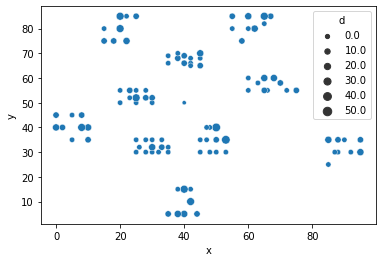

In [2]:
with open('data/vrp_101_10_1', 'r', encoding = 'utf-8') as f:
   n_locations, n_vehicles, cap = [int(x) for x in f.readline().split()]
   data = []
   for i in range(n_locations):
       data.append([float(x) for x in f.readline().split()])

data = np.array(data)
print(n_locations, n_vehicles, cap)
dataT = data.T
a = pd.DataFrame({'x':dataT[1], 'y':dataT[2] , 'd':dataT[0]})
sns.scatterplot(data=a, x='x', y='y', size='d', palette="deep")

## Creating a graph

In [3]:
class Graph:
    def __init__(self, x, y) -> None:
        self.n = n = len(x)
        self.x = np.array(x, dtype=float)
        self.y = np.array(y, dtype=float)
        self.edges = np.zeros(shape=(n,n), dtype=float)

        for i in range(self.n):
            for j in range(self.n):
                self.edges[i,j] = dist([x[i], y[i]], [x[j], y[j]])

        xf = np.average(self.edges)
        for i in range(self.n):
            self.edges[i,i] = xf

In [4]:
graph = Graph(dataT[1], dataT[2])
graph.edges[0]

array([39.07956935, 18.68154169, 20.61552813, 16.1245155 , 18.11077028,
       15.13274595, 19.        , 16.        , 18.11077028, 20.09975124,
       16.76305461, 19.6468827 , 38.07886553, 30.8058436 , 39.35733731,
       36.05551275, 40.31128874, 33.30165161, 35.35533906, 39.05124838,
       10.        , 10.19803903, 12.16552506, 13.        , 15.        ,
       15.13274595, 15.8113883 , 17.11724277, 17.72004515, 20.        ,
       20.61552813, 33.54101966, 31.6227766 , 33.52610923, 32.38826948,
       38.07886553, 35.35533906, 39.29376541, 41.23105626, 40.31128874,
       20.61552813, 18.68154169, 19.31320792, 16.55294536, 21.54065923,
       22.36067977, 20.59126028, 18.02775638, 23.32380758, 19.20937271,
       22.8035085 , 25.        , 21.21320344, 45.17742799, 40.04996879,
       35.05709629, 45.        , 35.        , 45.04442252, 35.05709629,
       45.27692569, 22.36067977, 18.02775638, 14.14213562, 21.54065923,
       12.80624847, 16.55294536, 12.20655562, 20.61552813, 15.81

## Make a set of plots for visualization before and after optimization

In [5]:
def split_lists(lst):
    lst = ' '.join(str(x) for x in lst).split(' 0 ')
    llst = []
    for x in lst:
        go = x.split(' ')
        go = [int(x) for x in go]
        if go[0] != 0:
            go.insert(0,0)
        if go[-1] != 0:
            go.insert(len(go),0)
        llst.append(go)
    return llst

In [6]:
def make_plots(costs, tour, graph):
  fig, ax =  plt.subplots(1, 2, figsize=(11, 5))

  # second plot, for cost vs iteration
  ax[0].set_ylabel('Value of best_ant.cost')
  ax[0].set_xlabel('Iteration #')
  ax[0].plot(costs)

  # third plot, for tour after optimization
  for tour in split_lists(tour):
    plot_x = []
    plot_y = []
    for i in tour:
        plot_x.append(graph.x[i])
        plot_y.append(graph.y[i])

    ax[1].set_ylabel('Y')
    ax[1].set_xlabel('X')
    ax[1].plot(plot_x, plot_y, marker='o', linestyle='dashed')

## Defining the objective funtion

In [7]:
def objective(tour, graph):
    fitn = 0
    n = len(tour)
    for i in range(n-1):
        fitn += graph.edges[tour[i], tour[i+1]]
    return fitn

## Creating the colony

In [8]:
class Ant:
    def __init__(self) -> None:
        self.tour = []
        self.cost = np.inf

    def __repr__(self) -> str:
        return f'Ant(tour={self.tour}, o={self.cost})'

    def __lt__(self, other):
        return self.cost < other.cost

class Colony:
    def __init__(self, graph, n_ants, tau, eta, alpha, beta, veh) -> None:
        self.n_vertex = n = graph.n
        self.n_ants = n_ants
        self.ants = [Ant() for i in range(n_ants)]

        for i in range(n_ants):
            self.ants[i].tour.append(0)
            for j in range(2, n + veh):
                last = self.ants[i].tour[-1]
                probs = (tau[last] ** alpha) * (eta[last] ** beta)
                probs[0] = np.average(probs)

                to_set = np.array(self.ants[i].tour)
                if np.count_nonzero(to_set == 0) == veh:
                    probs[to_set] = 0
                else:
                    to_set = np.delete(to_set, np.argwhere(to_set == 0))
                    probs[to_set] = 0

                # print(probs)
                probs = probs / np.sum(probs)
                self.ants[i].tour.append(np.random.choice(n, p=probs))
            self.ants[i].tour.append(0)

        for i in range(n_ants):
            self.ants[i].cost = objective(self.ants[i].tour, graph)

        self.queen = copy.deepcopy(min(self.ants))

## Function to update pheromones

In [9]:
def update_pheromones(colony, tau):
    n_ants = colony.n_ants
    n_vertex = colony.n_vertex

    for i in range(n_ants):
        for j in range(n_vertex - 1):
            cur, nxt = colony.ants[i].tour[j:j+2]
            tau[cur][nxt] += 1/colony.ants[i].cost
            tau[nxt][cur] += 1/colony.ants[i].cost

## Function to implement ACO

In [10]:
def run_ACO(n_ants, max_iter, graph, tau, eta, rho, alpha, beta, veh):

    best_ant = Ant()
    costs = []
    # taus = []

    for t in tqdm(range(max_iter)):
        # if t % 10 == 0:
        #     taus.append(np.max(tau, axis=1))
        colony = Colony(graph, n_ants, tau, eta, alpha, beta, veh)
        
        if colony.queen.cost < best_ant.cost:
            best_ant.tour = colony.queen.tour.copy()
            best_ant.cost = colony.queen.cost

        update_pheromones(colony, tau)
        tau = (1-rho) * tau

        costs.append(best_ant.cost)
    # sns.heatmap(taus)
    return best_ant, costs

100%|██████████| 500/500 [06:47<00:00,  1.23it/s]

Best cost :  617.4305051126782

Best tour :  [0, 23, 22, 21, 0, 5, 3, 7, 8, 9, 11, 10, 6, 4, 2, 1, 75, 0, 20, 0, 66, 69, 68, 64, 61, 72, 74, 62, 63, 65, 67, 0, 24, 25, 27, 29, 30, 28, 26, 34, 36, 39, 38, 37, 35, 31, 32, 33, 52, 50, 51, 48, 45, 44, 40, 41, 42, 43, 47, 49, 46, 59, 57, 55, 54, 53, 56, 58, 60, 80, 79, 77, 73, 70, 71, 76, 78, 81, 82, 83, 84, 85, 88, 89, 87, 86, 90, 91, 98, 96, 95, 94, 93, 92, 97, 100, 99, 12, 14, 16, 15, 19, 18, 17, 13, 0]


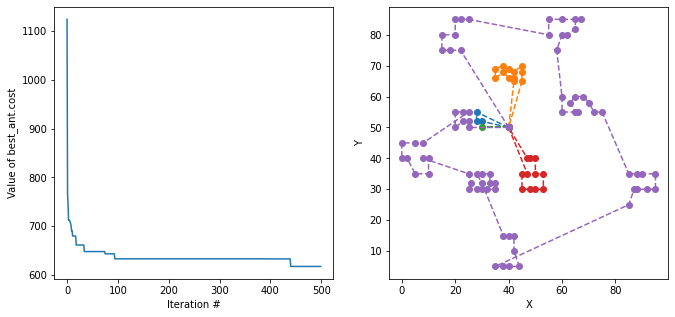

In [11]:
graph = Graph(dataT[1], dataT[2])

# creating eta matrix
with np.errstate(divide='ignore',invalid='ignore'):
    eta = 1/graph.edges
eta[eta == np.inf] = 0

# creating tau matrix
tau = np.full(eta.shape, 10/np.sum(graph.edges))

n_ants = graph.n
max_iter = 500
rho = 0.05
alpha = 1
beta = 2
veh = 5

best_ant, costs = run_ACO(n_ants, max_iter, graph, tau, eta, rho, alpha, beta, veh)
print('\nBest cost : ', best_ant.cost)
print('\nBest tour : ', best_ant.tour)
make_plots(costs, best_ant.tour, graph);